In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import seaborn as sns

from scipy.spatial.distance import pdist, squareform, cdist
from scipy import linalg
import scipy.sparse as sp

from wordcloud import WordCloud
import requests
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.pairwise import cosine_distances

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

import re
import nltk
from nltk.corpus import words 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
import contractions

In [2]:
# Fetch the 20 newsgroups dataset

	
categories = [
    "alt.atheism",
    "rec.sport.baseball", 
    "sci.space",
]


newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Create a DataFrame with data and target columns
data = pd.DataFrame({'data': newsgroups_data.data, 
                   'target': newsgroups_data.target, 
                   'target_names': [newsgroups_data.target_names[i] for i in newsgroups_data.target]})

In [3]:
print(data.columns)

Index(['data', 'target', 'target_names'], dtype='object')


In [4]:
# data_df = data.drop(["target","target_names"], axis=1)
# data_df

In [5]:
# Initialize components
lemmatizer = WordNetLemmatizer()
english_words = set(words.words())
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines()) 

# Precompiled regex patterns
html_tag_pattern = re.compile(r'<.*?>')
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
hyperlink_pattern = re.compile(r'http\S+|www.\S+')
non_ascii_pattern = re.compile(r'[^\x00-\x7F]+')
numbers_pattern = re.compile(r'\d+')
non_alphanumeric_pattern = re.compile(r'[^\w\s]')
underscore_pattern = re.compile(r'[_]+')
# short_words_pattern = re.compile(r'\b\w{1,2}\b')
multiple_spaces_pattern = re.compile(r'\s+')

# Function to map POS tag to WordNet POS for lemmatization
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
def clean_text(text):
    # Lowercasing early for normalization
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove HTML, emails, hyperlinks, non-ASCII, numbers, and non-alphanumeric characters in one pass each
    text = html_tag_pattern.sub('', text)
    text = email_pattern.sub('', text)
    text = hyperlink_pattern.sub('', text)
    text = non_ascii_pattern.sub(' ', text)
    text = numbers_pattern.sub(' ', text)
    text = non_alphanumeric_pattern.sub(' ', text)
    
    # Remove underscores and extra spaces
    text = underscore_pattern.sub(' ', text)
    text = multiple_spaces_pattern.sub(' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)
    
    # POS tagging and lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos))
        for token, pos in pos_tags
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(lemmatized_tokens)

In [7]:
data['data'] = data['data'].apply(clean_text)
data

,data,target,target_names
0,prominent recall longer display nasm museum st...,2,sci.space
1,wow remember movie hour long end universe reme...,2,sci.space
2,arrive joseph advantage mary speak word mary h...,0,alt.atheism
3,dennis work write proposal worth ten million c...,2,sci.space
4,mistake posted article fight food poisoning ho...,1,rec.sport.baseball
...,...,...,...
2775,ninth lead run score runner throw drive waaaaa...,1,rec.sport.baseball
2776,mail read sci space count server death cut sen...,2,sci.space
2777,rec music point random sample desperate respon...,1,rec.sport.baseball
2778,bosox royal clemens appier,1,rec.sport.baseball


In [8]:
# data_df_text = data["data"]
# data_df_text

In [9]:
# labels = data["target"].tolist()
# label_names = data["target_names"].tolist()
# len(labels)

In [10]:
# Create a TF-IDF vectorizer with default English stopwords and remove numbers
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.50, stop_words='english',token_pattern=r'\b[a-zA-Z]{3,}\b')

# Fit and transform the text data using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(data['data'])

# vectorizer = CountVectorizer(binary=True, min_df=3)
# binary_matrix = vectorizer.fit_transform(data_df_text)

In [11]:
data_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# data_df = pd.DataFrame(binary_matrix.toarray(), columns=vectorizer.get_feature_names_out())
data_df

,aaa,aaron,abbott,abbreviation,ability,aboard,abortion,absence,absolute,absolutely,...,yep,yesterday,york,young,youngster,yount,yup,zeile,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
valid_columns = [col for col in data_df.columns if col in english_words]
data_df = data_df[valid_columns]
data_df

,abbreviation,ability,aboard,abortion,absence,absolute,absolutely,absorb,abstract,absurd,...,yeah,year,yell,yep,yesterday,york,young,youngster,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
rows_with_all_zeroes = (data_df == 0).all(axis=1)
data_df = data_df.loc[~rows_with_all_zeroes]
indices_to_remove = rows_with_all_zeroes[rows_with_all_zeroes].index

In [15]:
labels = np.delete(data["target"], indices_to_remove)  # Remove entries from labels
label_names = np.delete(data["target_names"], indices_to_remove) 

In [16]:
# data_df["target"] = data["target"]
# data_df

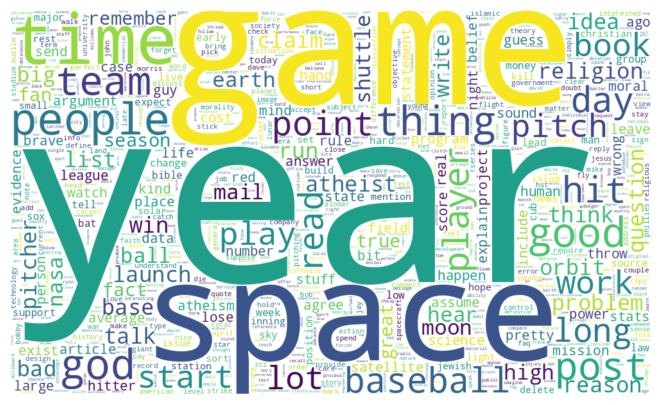

In [17]:
# feature_names = vectorizer.get_feature_names_out()
# binary_scores = binary_matrix.mean(axis=0).A1 

feature_names = tfidf_vectorizer.get_feature_names_out()
binary_scores = tfidf_matrix.mean(axis=0).A1 

# Create a dictionary with terms and their corresponding TF-IDF scores
binary_dict = dict(zip(feature_names, binary_scores))

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=1000).generate_from_frequencies(binary_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
# Correct the dictionary comprehension for renaming feature columns
feature_columns = {col: idx for idx, col in enumerate(data_df.columns)}
data_df.rename(columns=feature_columns, inplace=True)
data_df['target'] = data['target']

/var/folders/5m/3t1ykjr55_555tllby0d28j00000gn/T/ipykernel_31461/3568523944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.rename(columns=feature_columns, inplace=True)
/var/folders/5m/3t1ykjr55_555tllby0d28j00000gn/T/ipykernel_31461/3568523944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = data['target']


In [19]:
binary_vectors = tfidf_matrix.toarray()

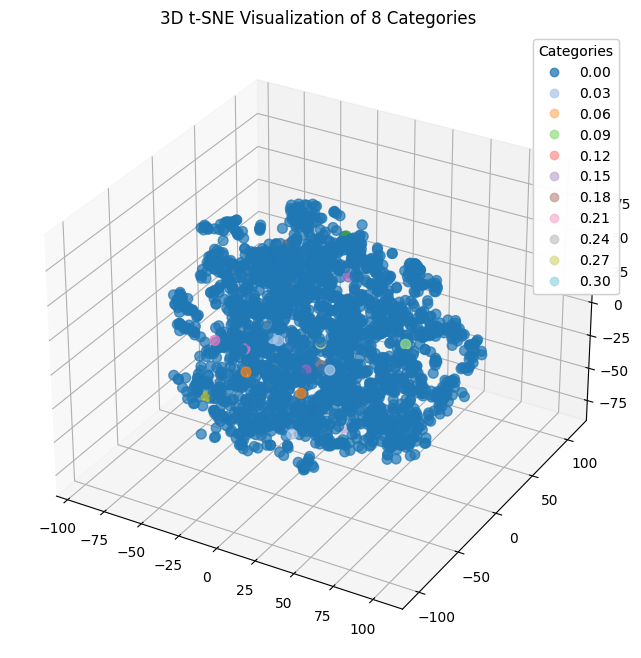

In [20]:
# Perform dimensionality reduction with PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(binary_vectors)

# Use t-SNE with 3 components
tsne_3d = TSNE(n_components=3, perplexity=50, n_iter=500, random_state=42)
tsne_result_3d = tsne_3d.fit_transform(pca_result)

# Scale the t-SNE result for better spacing
tsne_result_3d *= 5  # Adjust this factor for more or less spacing

# Create DataFrame for 3D visualization
df_3d = pd.DataFrame(tsne_result_3d, columns=['x', 'y', 'z'])
df_3d['target'] = data_df["target"]
# df_3d['label_name'] = df_3d['label'].apply(lambda i: label_names[i])

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(
    df_3d['x'], df_3d['y'], df_3d['z'], c=df_3d['target'], cmap='tab20', s=50, alpha=0.7
)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Categories")
ax.add_artist(legend1)
plt.title("3D t-SNE Visualization of 8 Categories")
plt.show()

In [22]:
def generate_subdatasets(data, fractions, target_column, dataset_name="20newsgroups"):
    np.random.seed(42)

    unique_classes = data[target_column].unique()

    # Split data by classes dynamically
    class_data = {cls: data[data[target_column] == cls] for cls in unique_classes}

    subdatasets = {}
    for fraction in fractions:
        samples_per_class = int(fraction * len(data) / len(unique_classes))
        subdataset = pd.concat([
            class_data[cls].sample(samples_per_class, random_state=42) for cls in unique_classes
        ])
        # Add an explicit "Index" column
        subdataset = subdataset.reset_index(drop=True)
        subdataset.insert(0, 'Index', subdataset.index)

        subdatasets[f"subdataset_{int(fraction * 100)}"] = subdataset

        # Save subdataset to respective folder
        fraction_dir = os.path.join(f"{dataset_name}_{int(fraction * 100)}")
        os.makedirs(fraction_dir, exist_ok=True)
        subdataset.to_csv(os.path.join(fraction_dir, f"{dataset_name}_{int(fraction * 100)}.csv"), index=False)

    # Full dataset
    data = data.reset_index(drop=True)
    data.insert(0, 'Index', data.index)  # Add "Index" column to full dataset
    subdatasets["subdataset_full"] = data
    full_dir = os.path.join(f"{dataset_name}_full")
    os.makedirs(full_dir, exist_ok=True)
    data.to_csv(os.path.join(full_dir, f"{dataset_name}_full.csv"), index=False)

    return subdatasets

In [23]:
subdatasets = generate_subdatasets(data_df, [0.33, 0.66], 'target', dataset_name="20newsgroups")
print(subdatasets['subdataset_33']['target'].value_counts())
print(subdatasets['subdataset_66']['target'].value_counts())
print(subdatasets['subdataset_full']['target'].value_counts())

target
2    292
0    292
1    292
Name: count, dtype: int64
target
2    585
0    585
1    585
Name: count, dtype: int64
target
2    949
1    939
0    775
Name: count, dtype: int64
